This notebook is created by Bilas Pal, PhD, email: drbilaspal@gmail.com

###  R&D Data Science Capability Test

The purpose of this test is to understand not just your programming ability, but how you formulate problems and think about solution architectures. We encourage you to take risk where you can articulate the value of that risk and engage in dialog with the interview team, over 'playing it safe'.

__Data__
You are provided a dataset of 36000 ratings and reviews of a Pampers product. These reviews were created in Chinese, but 'best effort' English translations are provided

__Test__
This is an open-ended Data Science test on what insights you can extract from the dataset in a 24-hr turnaround time. In the follow-on phone interview, we will dialog with you to understand your thinking on:
-	problem selection, 
-	problem approach, 
-	exploration of dataset sufficiency to address problem, 
-	success metrics, 
-	and one specific follow-on project you would attempt if you had more time (e.g. 2 weeks)

We are interested to learn what consumers are telling us about our products.  What do they like and dislike?  What actions might we consider based on this feedback?  Also, the candidate can explore this data in whatever ways make sense to him/her.

The candidate is expected to share an executable Ipython notebook (and a pdf) for the interview team to be able to run and reproduce the results indicated in the pdf version. The Ipython notebook is expected to have enough context for the code, but not expected to be a refined data science report.


### Initial Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

In [2]:
#import the data set
df = pd.read_excel('ds-nlp-interview-question_v2.xlsx')

### Exploratory Data Analysis and Visualizations

In [3]:
#first few samples, 
df.head(2)

,REVIEW_TEXT_CN,REVIEW_TEXT_EN,ONLINE_STORE,BRAND,YEAR,MONTH
0,花王的确实不错，一直用这个牌子,"Kao is really good, always use this brand",tmall,Merries,2016,11
1,哈哈哈哈，真心不错的啊。没有异味，非常非常的柔软，吸收量很大，并且不起球，大品牌值得信赖，物...,"Hahahaha, really good. No odor, very very soft...",suning,Huggies,2017,1


In [4]:
#lets drop the 'REVIEW_TEXT_CN' column and use the best effort English Translation for our analysis
df = df.drop(['REVIEW_TEXT_CN'], axis=1)
df.head(2)

,REVIEW_TEXT_EN,ONLINE_STORE,BRAND,YEAR,MONTH
0,"Kao is really good, always use this brand",tmall,Merries,2016,11
1,"Hahahaha, really good. No odor, very very soft...",suning,Huggies,2017,1


In [5]:
#information about the data set
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36000 entries, 0 to 35999
Data columns (total 5 columns):
REVIEW_TEXT_EN    36000 non-null object
ONLINE_STORE      36000 non-null object
BRAND             36000 non-null object
YEAR              36000 non-null int64
MONTH             36000 non-null int64
dtypes: int64(2), object(3)
memory usage: 1.4+ MB


Data set looks good, no null value in any columns! Now let's look the `YEAR` and `MONTH` columns to see whether there are any nonsense yeras/months.

In [6]:
#unique years
df.YEAR.value_counts()

2017    9626
2014    7107
2015    6866
2016    5572
2018    4700
2013    1951
1900     178
Name: YEAR, dtype: int64

In [7]:
#unique months
df.MONTH.value_counts()

11    4752
4     3544
12    3473
3     3467
1     3389
6     3149
10    2716
2     2692
5     2667
7     2144
8     2085
9     1744
0      178
Name: MONTH, dtype: int64

__Insight :__ There are 178 reviews in the year of 1900 and month 0. This does not make any sense. This may be due to some mistake while extracting the data from web. Let's not worry about this, as it is only about 0.5% of the data set. For future analysis, we are not considering these samples.

In [8]:
df  = df[df.YEAR != 1900]

In [9]:
df.YEAR.value_counts()

2017    9626
2014    7107
2015    6866
2016    5572
2018    4700
2013    1951
Name: YEAR, dtype: int64

The number of reviews is relatively less in 2013 than other years. This is probably due to the start date of this data set at the middle of 2013. Also the end date of this data set seems to be middle of 2018. Let's now justify this. 

In [10]:
df[df['YEAR']==2013]['MONTH'].value_counts()

12    729
11    724
10    498
Name: MONTH, dtype: int64

In [11]:
df[df['YEAR']==2018]['MONTH'].value_counts()

1    858
3    797
4    756
5    685
6    650
2    503
7    451
Name: MONTH, dtype: int64

Yes, we are right! The start date is October 2013 and end date is July 2018!

Now let's visualize which `BRAND` gets more review

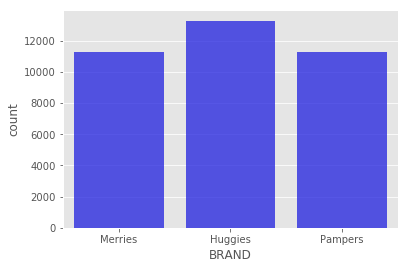

In [12]:
plt.style.use('ggplot')
sns.countplot(df['BRAND'],color='blue',alpha=0.75)

In [13]:
df.BRAND.value_counts(normalize=True)

Huggies    0.370582
Pampers    0.314751
Merries    0.314667
Name: BRAND, dtype: float64

`Huggies` got more reviews than `P&G`'s `Pampers` brand, while `Merries` gets almost similar number of reviews as of `Pampers`. Let's now focus on the `Pampers` brand only, as one of our main goal is learn more about this brand. 

Let's now see the online shop from where customers buy `Pampers`.

In [14]:
pampers =  df[df['BRAND']=='Pampers']
pampers.reset_index(inplace=True)

In [15]:
pampers.ONLINE_STORE.str.lower().value_counts(normalize=True)

jingdong             0.735965
tmall                0.084701
tmall_supermarket    0.064568
tmall_pampers        0.055078
suning               0.026519
yihaodian            0.021818
dangdang             0.007184
vip                  0.002306
amazon               0.001330
tmall_globalstore    0.000532
Name: ONLINE_STORE, dtype: float64

Looks like `jingdong` is most popular online shopping in China (at least for this data set): about 74% of total `Pampers` review comes from this store. 

### Text Cleaning

In [17]:
#import cleaning library
import re
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from bs4 import BeautifulSoup
from textblob import TextBlob

ImportError: No module named 'textblob'

In [ ]:
def review_to_words( raw_review ):
    # Function to convert a raw review to a string of words
    # The input is a single string (a raw  review), and 
    # the output is a single string (a preprocessed  review)
    #
    # 1. Remove HTML
    review_text = BeautifulSoup(raw_review).get_text() 
    #
    # 2. Remove non-letters        
    letters_only = re.sub("[^a-zA-Z]", " ", review_text) 
    #
    # 3. Convert to lower case, split into individual words
    words = letters_only.lower().split()                             
    #
    # 4. In Python, searching a set is much faster than searching
    #   a list, so convert the stop words to a set
    stops = set(stopwords.words("english"))                  
    # 
    ps = PorterStemmer() 
    #stemming will take the root of the word
    #there are many stemmer available
    # 5. Remove stop words
    meaningful_words = [ps.stem(w) for w in words if not w in stops]   
    #
    # 6. Join the words back into one string separated by space, 
    # and return the result.
    return( " ".join( meaningful_words ))

In [ ]:
pampers['REVIEW_TEXT_EN'][0]

In [ ]:
#lets check 1st clean review
clean_rev = review_to_words(pampers['REVIEW_TEXT_EN'][0])

In [20]:
clean_rev

'feel differ one bought store big tast uneven place sometim print children other fine'

In [21]:
pampers['Review_processed'] = pampers['REVIEW_TEXT_EN'].apply(review_to_words)

In [22]:
pampers['Review_processed'].head()

0    feel differ one bought store big tast uneven p...
1    much cheaper physic store worth price day eval...
2    first time bought pamper know true feel bad go...
3    first time bought someth tmall supermarket del...
4    urin wet tast urin know anyth chang mommi babi...
Name: Review_processed, dtype: object

__Sentiment analysis__ is basically the process of determining the attitude or the emotion of the writer, i.e., whether it is positive or negative or neutral.

The sentiment function of `textblob` returns two properties, `polarity`, and `subjectivity`.

__Polarity__ is float which lies in the range of [-1,1] where 1 means positive statement and -1 means a negative statement. __Subjective__ sentences generally refer to personal opinion, emotion or judgment whereas __objective__ refers to factual information. Subjectivity is also a float which lies in the range of [0,1].

Here we are going to use thr __polarity__

In [23]:
def sentiment(x):
    sentiment = TextBlob(x)
    return sentiment.sentiment.polarity

In [24]:
pampers['Review_polarity'] = pampers['Review_processed'].apply(sentiment)

In [25]:
pampers['Polarity'] = ''
pampers['Polarity'][pampers['Review_polarity'] > 0] = 'positive'
pampers['Polarity'][pampers['Review_polarity'] < 0] = 'negative'
pampers['Polarity'][pampers['Review_polarity'] == 0] = 'neutral'

In [26]:
pampers['Polarity'].value_counts(normalize=True)

positive    0.670333
neutral     0.177827
negative    0.151840
Name: Polarity, dtype: float64

Great! About 67% review seems to be positive! Let's visualize this.

Text(0.5, 1.0, 'Review Polarity')

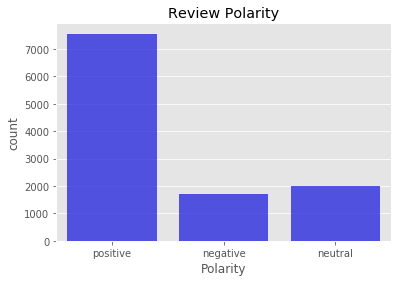

In [27]:
sns.countplot(pampers['Polarity'],color='blue',alpha=0.75)
plt.title('Review Polarity')

__WordCloud__ is a technique to show which words are the most frequent among the given text. Let's utilize this to know about the common words in different review polarity.

In [28]:
df_posr  = pd.DataFrame(pampers['Review_processed'][ pampers['Polarity'] == 'positive'])
df_negr  = pd.DataFrame(pampers['Review_processed'][ pampers['Polarity'] == 'negative'])
df_neutr = pd.DataFrame(pampers['Review_processed'][ pampers['Polarity'] == 'neutral'])

In [29]:
from wordcloud import WordCloud, STOPWORDS

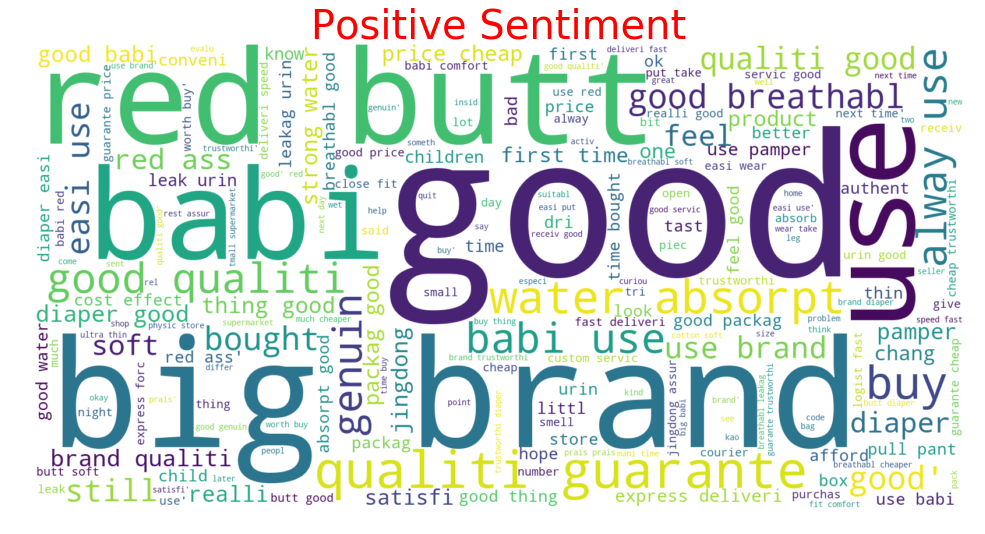

In [30]:
wordcloud = WordCloud(width=1600, height=800, random_state=1, max_words=200, background_color='white',)
wordcloud.generate(str(set(df_posr['Review_processed'])))
# declare our figure 
plt.figure(figsize=(20,10))
plt.title("Positive Sentiment", fontsize=40,color='Red')
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.tight_layout(pad=10)
plt.show()

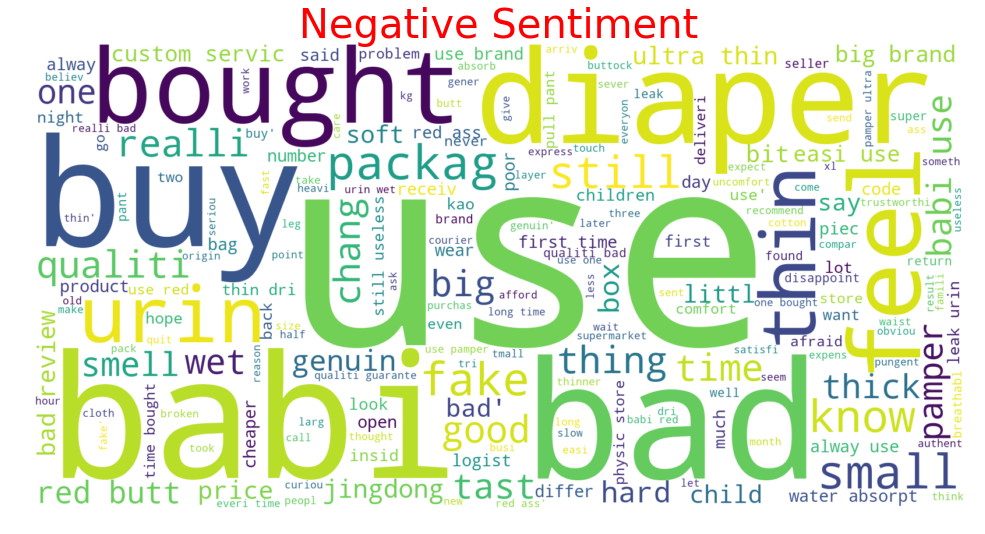

In [31]:
wordcloud = WordCloud(width=1600, height=800, random_state=1, max_words=200, background_color='white',)
wordcloud.generate(str(set(df_negr['Review_processed'])))
# declare our figure 
plt.figure(figsize=(20,10))
plt.title("Negative Sentiment", fontsize=40,color='Red')
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.tight_layout(pad=10)
plt.show()

Some the negative comments we may need to consider to improve the quality are __ultra thin__, __leak urin__, __smell__, __red ass__(although it appears also in positive sentiment), __wet__, __uncomfort__, __broken__, __price__ etc.

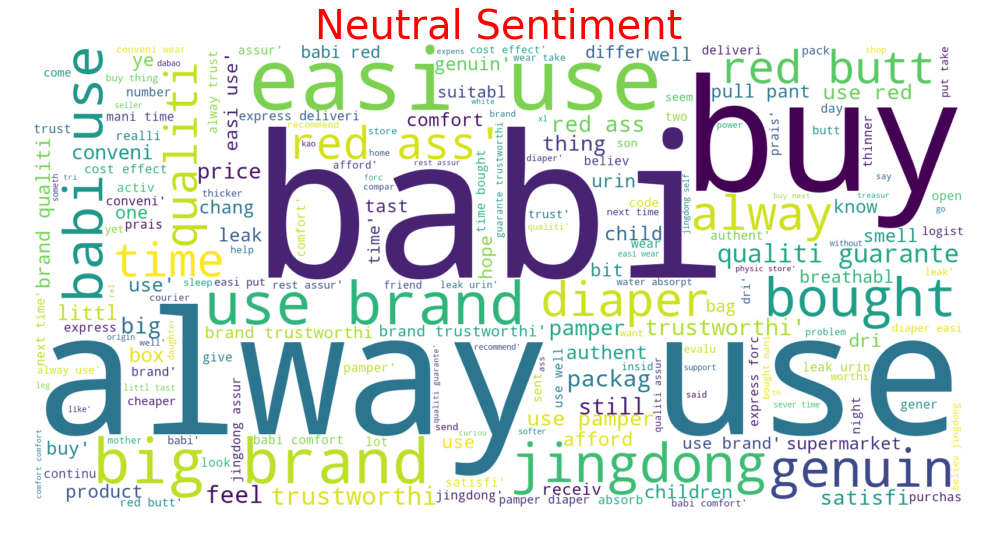

In [32]:
wordcloud = WordCloud(width=1600, height=800, random_state=1, max_words=200, background_color='white',)
wordcloud.generate(str(set(df_neutr['Review_processed'])))
# declare our figure 
plt.figure(figsize=(20,10))
plt.title("Neutral Sentiment", fontsize=40,color='Red')
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.tight_layout(pad=10)
plt.show()

Let's now compare `Pampers` with `Huggies`. Specially we are interested about the sentiments in `Huggies` brand. What people write about other barnds.

In [33]:
huggies =  df[df['BRAND']=='Huggies']
huggies.reset_index(inplace=True)

In [34]:
huggies['Review_processed'] = huggies['REVIEW_TEXT_EN'].apply(review_to_words)

In [35]:
huggies['Review_polarity'] = huggies['Review_processed'].apply(sentiment)

In [36]:
huggies['Polarity'] = ''
huggies['Polarity'][huggies['Review_polarity'] > 0] = 'positive'
huggies['Polarity'][huggies['Review_polarity'] < 0] = 'negative'
huggies['Polarity'][huggies['Review_polarity'] == 0] = 'neutral'

Text(0.5, 1.0, 'Review Polarity')

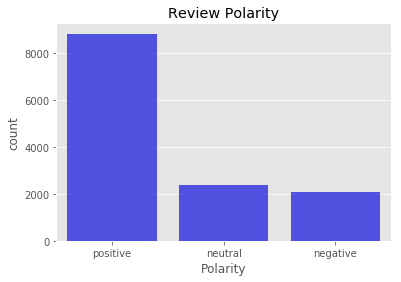

In [37]:
sns.countplot(huggies['Polarity'],color='blue',alpha=0.75)
plt.title('Review Polarity')

In [38]:
h_posr  = pd.DataFrame(huggies['Review_processed'][ huggies['Polarity'] == 'positive'])
h_negr  = pd.DataFrame(huggies['Review_processed'][ huggies['Polarity'] == 'negative'])
h_neutr = pd.DataFrame(huggies['Review_processed'][ huggies['Polarity'] == 'neutral'])

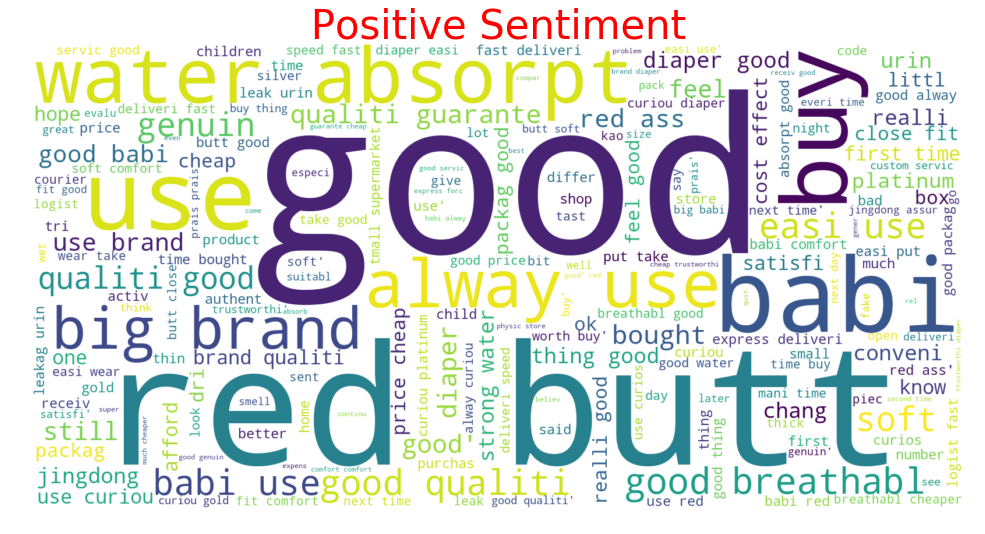

In [39]:
wordcloud = WordCloud(width=1600, height=800, random_state=1, max_words=200, background_color='white',)
wordcloud.generate(str(set(h_posr['Review_processed'])))
# declare our figure 
plt.figure(figsize=(20,10))
plt.title("Positive Sentiment", fontsize=40,color='Red')
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.tight_layout(pad=10)
plt.show()

### Some Comments
- `Huggies` may be __cheaper__ than `Pampers` brand, this can be taken care
- `Huggies` seems __soft__, which parents might like
- Also as we mentioned earlier that the phrase appeared in the negative sentiment e.g. __ultra thin__, __leak urin__, __smell__, __red ass__, __wet__, __uncomfort__, __broken__, __price__ could be considered.

to improve the quality. 

With more time, other text mining method could be performed to get other insight from this data set. Also the library `Polyglot` could be utilized, which has the ability to translate from one language to another. 